# Task 2 - Classification project: Modelling Consumer Response to Marketing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Clothing_Store.csv") # load CSV file
df.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


In [3]:
df.shape   # no.of customers and fileds

(21740, 51)

## data cleaning

In [4]:
X = df.iloc[:, :-1]

phone = pd.get_dummies(X['VALPHON'], drop_first=True) # Get dummy
phone = phone.rename(columns = {'Y':'VALPHON'})

X = X.drop('VALPHON', axis=1)
X = X.drop('HHKEY', axis=1)
X = X.drop('ZIP_CODE', axis=1)

# Cleaned Variables & target
X = pd.concat([X, phone], axis=1)
y = df.iloc[:,-1]

# missing value check
import scipy as sp
print(sp.sum(sp.isnan(X)))
print(sp.sum(sp.isnan(y)))

REC             0
FRE             0
MON             0
CC_CARD         0
AVRG            0
PC_CALC20       0
PSWEATERS       0
PKNIT_TOPS      0
PKNIT_DRES      0
PBLOUSES        0
PJACKETS        0
PCAR_PNTS       0
PCAS_PNTS       0
PSHIRTS         0
PDRESSES        0
PSUITS          0
POUTERWEAR      0
PJEWELRY        0
PFASHION        0
PLEGWEAR        0
PCOLLSPND       0
AMSPEND         0
PSSPEND         0
CCSPEND         0
AXSPEND         0
TMONSPEND       0
OMONSPEND       0
SMONSPEND       0
PREVPD          0
GMP             0
PROMOS          0
DAYS            0
FREDAYS         0
MARKDOWN        0
CLASSES         0
COUPONS         0
STYLES          0
STORES          0
STORELOY        0
WEB             0
MAILED          0
RESPONDED       0
RESPONSERATE    0
HI              0
LTFREDAY        0
CLUSTYPE        0
PERCRET         0
VALPHON         0
dtype: int64
0


## data understanding & preparation

In [5]:
# propostion of responder
print("Proportion of responders: {0:.2f}%".format(float(sum(y))/float(len(y))*100))

Proportion of responders: 16.61%


In [6]:
# Microvision lifestyle cluster type
from collections import Counter
style = Counter(X['CLUSTYPE'])
style_prob = [(i, style[i] / len(X['CLUSTYPE']) * 100.0) for i, count in style.most_common()]
style_prob = pd.DataFrame(style_prob)
style_prob = pd.DataFrame({'lifestyle':style_prob[0], 'prob': style_prob[1]})
style_prob.head()

,lifestyle,prob
0,10,12.065317
1,1,9.448022
2,4,7.907084
3,16,6.582337
4,8,5.032199


In [42]:
# skew + kurtosis
descrip = X.describe()
descrip.loc['skew', :] = X.skew()
descrip.loc['kurt', :] = X.kurt()

print(descrip.round(3))

             REC        FRE        MON       AVRG  PC_CALC20    CCSPEND  \
count  21740.000  21740.000  21740.000  21740.000  21740.000  21740.000   
mean      -0.000      0.000      0.000      0.000      0.000      0.000   
std        1.000      1.000      1.000      1.000      1.000      1.000   
min       -3.471     -1.222     -5.844     -7.836     -0.643     -8.095   
25%       -0.608     -1.222     -0.772     -0.607     -0.643     -0.549   
50%        0.221     -0.047     -0.087      0.010     -0.643     -0.012   
75%        0.819      0.695      0.707      0.633      1.429      0.645   
max        1.279      3.853      4.499      4.562      2.379      4.221   
skew      -0.927      0.468      0.248     -0.197      0.974     -0.433   
kurt       0.401     -0.500      0.043      1.041     -0.885      2.017   

            DAYS    FREDAYS    CLASSES     STYLES    ...      RESPONDED  \
count  21740.000  21740.000  21740.000  21740.000    ...      21740.000   
mean       0.000      0.

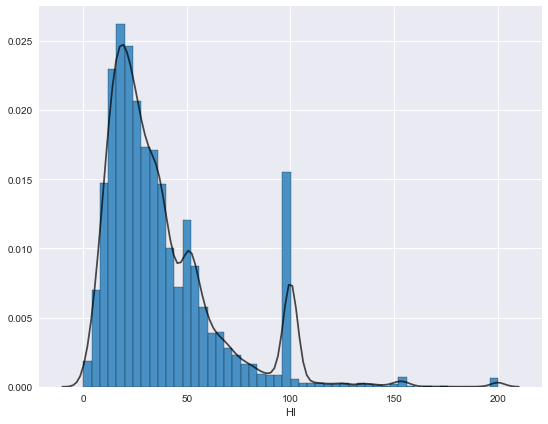

In [8]:
# skewness example
def hist(series):
    fig,ax=plt.subplots(figsize=(9,7))
    sns.distplot(series,ax=ax,hist_kws={'alpha':0.9, 'edgecolor':'black','color':sns.color_palette('Blues', n_colors=2)[-1]},
                                        kde_kws={'color':'black','alpha':0.7})
    return fig, ax

fig = plt.figure()
hist(X['HI'])
sns.despine()   
plt.show()
fig.savefig('Product uniformity.pdf')      #### [存不下来啊？！！？！,自定义的function？]

### Numerical variables

#### Normalization

In [9]:
# numerical variables
from sklearn import preprocessing
X_num = X.drop(['CC_CARD','VALPHON','WEB'], axis=1)

# no '0' - natural log transformation
X_num1 = X_num.loc[:, (X_num != 0).all(axis=0)]
X_log = np.log(X_num1)

# contain '0' - square root transformation 
X_num0 = X_num.drop(X_num1, axis=1)
X_sqrt = np.sqrt(X_num0)

# concate log & sqrt 
X_num = pd.concat([X_log, X_sqrt], axis=1)

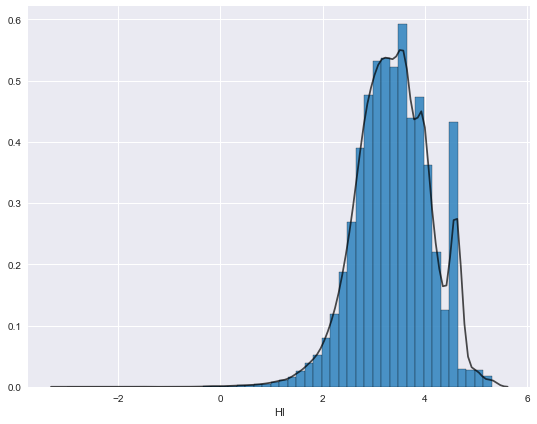

In [10]:
fig = plt.figure()
hist(X_num['HI'])
sns.despine()   
plt.show()
fig.savefig('Product uniformity_norm.pdf') 

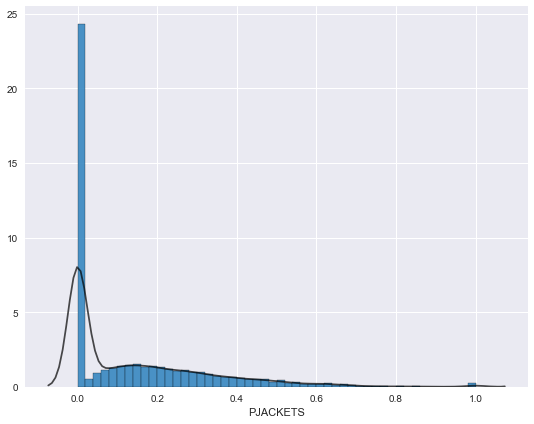

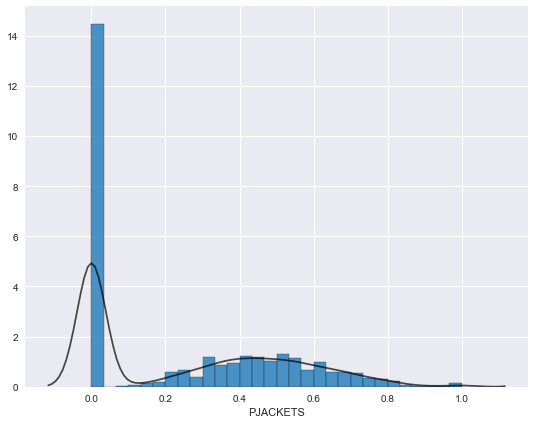

In [11]:
# 15 closing varaibles - choose one as example
fig = plt.figure()
hist(X['PJACKETS'])
hist(X_num['PJACKETS'])
sns.despine() 
plt.show()
fig.savefig('PJACKETS.pdf')      #### [存不下来啊？！！？！,自定义的function？]

In [12]:
# zero spike
jacket = Counter(X_num['PJACKETS'])
print("Proportion of not buy jackets: {0:.2f}%".format(jacket[0]/len(X_num['PJACKETS']) * 100.0))

Proportion of not buy jackets: 48.17%


#### Standardization

In [28]:
# differences in std
descrip = X_num.describe()
print("std of last 6mos spend: {0:.2f}".format(np.std(X_num['SMONSPEND'])))
print("std of coupon spend: {0:.2f}".format(np.std(X_num['COUPONS'])))

std of last 6mos spend: 10.01
std of coupon spend: 0.74


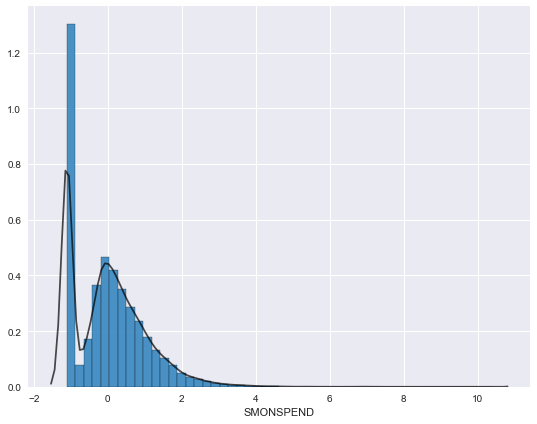

In [14]:
# z-score standardize
from sklearn import preprocessing
X_scale = preprocessing.scale(X_num)
X_scale = pd.DataFrame(X_scale, columns = X_num.columns, index = X_num.index)

# one variable to prove [6mos spend]
plt.figure()
hist(X_scale['SMONSPEND'])
sns.despine() 
plt.show()
fig.savefig('SMONSPEND.pdf')   

#### derive new variables

##### amount spent series

In [15]:
X_spent = X_scale[['TMONSPEND', 'OMONSPEND', 'SMONSPEND']]

X_spent23 = X_scale['TMONSPEND']-X_scale['OMONSPEND']
X_spent23 = pd.DataFrame({'2-3MONSPEND': X_spent23})

X_spent46 = X_scale['SMONSPEND']-X_scale['TMONSPEND']
X_spent46 = pd.DataFrame({'4-6MONSPEND': X_spent46})

# replace TMONSPEND & SMONSPEND to 23spent & 46spent
X_spent_n= pd.concat([X_spent['OMONSPEND'], X_spent23, X_spent46], axis=1)
X_scale = X_scale.drop(X_spent, axis=1)
X_scale = pd.concat([X_scale, X_spent_n], axis=1)

##### functional relationship

In [16]:
X_func = X_scale[['FRE', 'MON', 'AVRG']]
X_func_corr = X_func.corr()
#return this to below~~~~

### Rough: Relationships b/w the Predictors and the Response

In [17]:
# merge catogritical variables back
X_cal = X[['CC_CARD', 'VALPHON', 'WEB']]
X = pd.concat([X_scale, X_cal], axis = 1)

In [18]:
corr_y = X.corrwith(y).sort_values(ascending = False)
corr_y_abs = X.corrwith(y).abs().sort_values(ascending = False)
print(corr_y.head(8))
print(corr_y_abs.head(8))

FRE             0.400003
STYLES          0.368682
RESPONDED       0.337048
MON             0.333518
CLASSES         0.328448
COUPONS         0.324806
RESPONSERATE    0.322675
STORES          0.285777
dtype: float64
LTFREDAY     0.434007
FRE          0.400003
STYLES       0.368682
RESPONDED    0.337048
MON          0.333518
CLASSES      0.328448
COUPONS      0.324806
FREDAYS      0.323180
dtype: float64


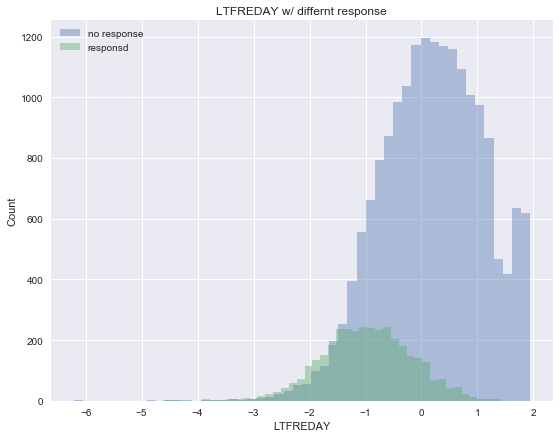

In [19]:
# highest corr variable plot 
lifevisit= pd.concat([X['LTFREDAY'], y], axis =1)
lifevisit_1 = lifevisit[lifevisit['RESP'] !=0]
lifevisit_0= lifevisit[lifevisit['RESP'] ==0]

fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(lifevisit_0['LTFREDAY'],bins=None, ax=ax, kde=False, label='no response')
sns.distplot(lifevisit_1['LTFREDAY'],bins=None, ax=ax, kde=False, label='responsd')
plt.legend()
plt.ylabel("Count")
plt.title("LTFREDAY w/ differnt response")
plt.savefig('LTFREDAY with differnt response.pdf')

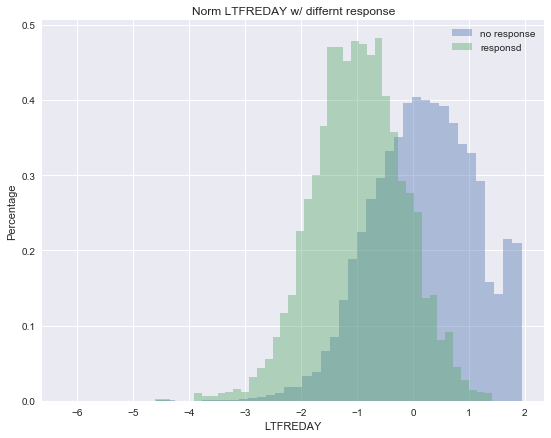

In [20]:
# normalize histograph
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(lifevisit_0['LTFREDAY'],bins=None, ax=ax, norm_hist = True, kde=False, label='no response')
sns.distplot(lifevisit_1['LTFREDAY'],bins=None, ax=ax, norm_hist = True, kde=False, label='responsd')
plt.legend()
plt.ylabel("Percentage")
plt.title("Norm LTFREDAY w/ differnt response")
plt.savefig('Norm LTFREDAY with differnt response.pdf')

 # [这他妈y轴为什么不是sum在1？？？？]

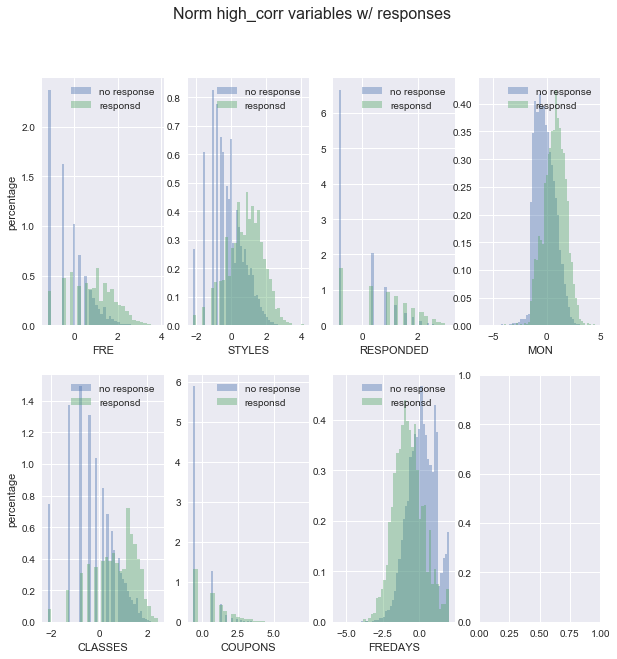

In [21]:
#other high corrs
high_corr = X[['FRE', 'STYLES', 'RESPONDED', 'MON', 'CLASSES', 'COUPONS', 'FREDAYS']]
high_corr = pd.concat([high_corr, y], axis=1)
high_corr_1 = high_corr[high_corr['RESP'] !=0]
high_corr_0 = high_corr[high_corr['RESP'] ==0]

# Set up the matplotlib figure
f, axes = plt.subplots(2, 4, figsize=(10,10))
sns.despine(left=True)

# subplots
sns.distplot(high_corr_0['FRE'],bins=None, ax=axes[0,0], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['FRE'],bins=None, ax=axes[0,0], norm_hist = True, kde=False, label='responsd')
axes[0,0].legend(loc="upper right")

sns.distplot(high_corr_0['STYLES'],bins=None, ax=axes[0,1], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['STYLES'],bins=None, ax=axes[0,1], norm_hist = True, kde=False, label='responsd')
axes[0,1].legend(loc="upper right")

sns.distplot(high_corr_0['RESPONDED'],bins=None, ax=axes[0,2], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['RESPONDED'],bins=None, ax=axes[0,2], norm_hist = True, kde=False, label='responsd')
axes[0,2].legend(loc="upper right")

sns.distplot(high_corr_0['MON'],bins=None, ax=axes[0,3], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['MON'],bins=None, ax=axes[0,3], norm_hist = True, kde=False, label='responsd')
axes[0,3].legend(loc="upper right")

sns.distplot(high_corr_0['CLASSES'],bins=None, ax=axes[1,0], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['CLASSES'],bins=None, ax=axes[1,0], norm_hist = True, kde=False, label='responsd')
axes[1,0].legend(loc="upper right")

sns.distplot(high_corr_0['COUPONS'],bins=None, ax=axes[1,1], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['COUPONS'],bins=None, ax=axes[1,1], norm_hist = True, kde=False, label='responsd')
axes[1,1].legend(loc="upper right")

sns.distplot(high_corr_0['FREDAYS'],bins=None, ax=axes[1,2], norm_hist = True, kde=False, label='no response')
sns.distplot(high_corr_1['FREDAYS'],bins=None, ax=axes[1,2], norm_hist = True, kde=False, label='responsd')
axes[1,2].legend(loc="upper right")

axes[0,0].set_ylabel('percentage')
axes[1,0].set_ylabel('percentage')
plt.suptitle('Norm high_corr variables w/ responses', fontsize=16)

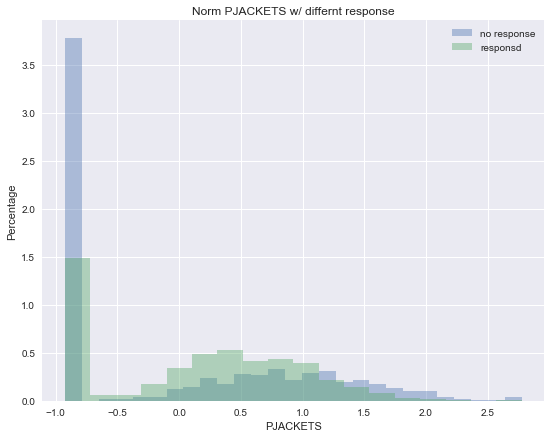

In [23]:
# Norm privious closing percentage varaible w. response [这他妈y轴为什么不是sum在1？？？？]
jacket = pd.concat([X['PJACKETS'], y], axis=1)
jacket_1 = jacket[jacket['RESP'] !=0]
jacket_0= jacket[jacket['RESP'] ==0]

#plot
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(jacket_0['PJACKETS'],bins=None, ax=ax, norm_hist = True, kde=False, label='no response')
sns.distplot(jacket_1['PJACKETS'],bins=None, ax=ax, norm_hist = True, kde=False, label='responsd')
plt.legend()
plt.ylabel("Percentage")
plt.title("Norm PJACKETS w/ differnt response")
plt.savefig('Norm PJACKETS with differnt response.pdf')

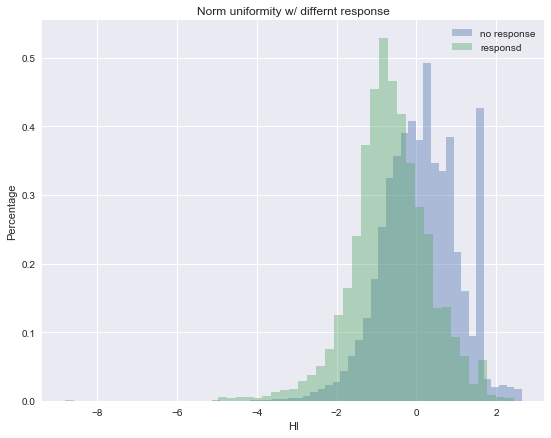

In [24]:
# Norm Uniformity w/ response
uni = pd.concat([X['HI'], y], axis=1)
uni_1 = uni[uni['RESP'] !=0]
uni_0= uni[uni['RESP'] ==0]

#plot
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(uni_0['HI'],bins=None, ax=ax, norm_hist = True, kde=False, label='no response')
sns.distplot(uni_1['HI'],bins=None, ax=ax, norm_hist = True, kde=False, label='responsd')
plt.legend()
plt.ylabel("Percentage")
plt.title("Norm uniformity w/ differnt response")
plt.savefig('Norm uniformity with differnt response.pdf')

### correlation b/w variables - multicollinearity

In [43]:
corr_matrix = X.corr()
corr_index = corr_matrix.index

# high corr 
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= 0.8:
            if corr_index[i] != corr_index[j]:
                print('high corr exist(+ve): ' +corr_index[i]+ ',' +corr_index[j])
                print(corr_matrix.iloc[i, j].round(2))
        if corr_matrix.iloc[i, j] <= -0.8:  
            if corr_index[i] != corr_index[j]:
                print('high corr exist(-ve): ' +corr_index[i]+ ',' +corr_index[j])
                print(corr_matrix.iloc[i, j].round(2))

high corr exist(+ve): CLASSES,FRE
0.8
high corr exist(+ve): CLASSES,MON
0.84
high corr exist(+ve): STYLES,FRE
0.86
high corr exist(+ve): STYLES,MON
0.88
high corr exist(+ve): STYLES,CLASSES
0.92
high corr exist(-ve): HI,CLASSES
-0.8
high corr exist(+ve): LTFREDAY,FREDAYS
0.82
high corr exist(+ve): MAILED,PROMOS
0.9
high corr exist(+ve): RESPONSERATE,RESPONDED
0.94


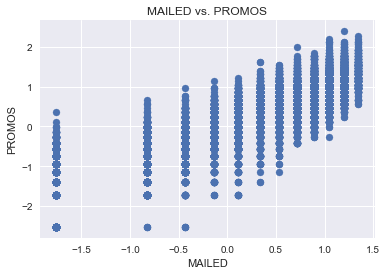

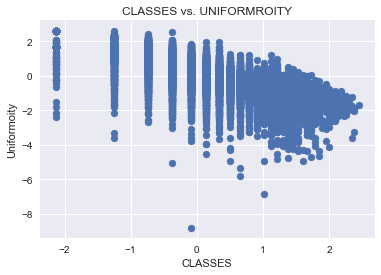

In [35]:
# scatter plot -examples
# positive relationship
fig = plt.figure()
plt.scatter(X['MAILED'], X['PROMOS'])
plt.xlabel("MAILED")
plt.ylabel("PROMOS")
plt.title("MAILED vs. PROMOS")
plt.savefig("MAILED vs PROMOS.pdf")
 
# negative relationship
fig = plt.figure()
plt.scatter(X['CLASSES'], X['HI'])
plt.xlabel("CLASSES")
plt.ylabel("Uniformoity")
plt.title("CLASSES vs. UNIFORMROITY")
plt.savefig("CLASSES vs. UNIFORMROITY.pdf")

In [34]:
# Jacket on flags varaibles & response  [sample]
jacket_flags = pd.concat([jacket, X_cal], axis =1)

# prop w/ card + respond
cardj = jacket_flags[(jacket_flags['PJACKETS'] != 0) & (jacket_flags['RESP'] !=0) & (jacket_flags['CC_CARD'] !=0)]
cardj_prob = cardj['PJACKETS'].count()/len(y) *100
print("+ve response on Card for jacket buyer : {0:.2f}%".format(cardj_prob))                    

phonej = jacket_flags[(jacket_flags['PJACKETS'] != 0) & (jacket_flags['RESP'] !=0) & (jacket_flags['VALPHON'] !=0)]
phonej_prob = phonej['PJACKETS'].count()/len(y) *100
print("+ve response on Phone for jacket buyer : {0:.2f}%".format(phonej_prob))                    

webj = jacket_flags[(jacket_flags['PJACKETS'] != 0) & (jacket_flags['RESP'] !=0) & (jacket_flags['WEB'] !=0)]
webj_prob = webj['PJACKETS'].count()/len(y) *100
print("+ve response on Web for jacket buyer: {0:.2f}%".format(webj_prob))                    

+ve response on Card for jacket buyer : 10.74%
+ve response on Phone for jacket buyer : 15.63%
+ve response on Web for jacket buyer: 1.88%


### derive other Flag varaibles

In [52]:
# variables contain categorical meaning
types = df[['PSWEATERS','PKNIT_TOPS','PKNIT_DRES','PBLOUSES','PJACKETS','PCAR_PNTS','PCAS_PNTS','PSHIRTS','PDRESSES','PSUITS','POUTERWEAR','PJEWELRY','PFASHION','PLEGWEAR','PCOLLSPND']]
spent = df[['AMSPEND','PSSPEND','CCSPEND','AXSPEND','OMONSPEND','TMONSPEND','SMONSPEND','PREVPD']]
others = df[['RESPONSERATE','PERCRET']]

# binary those variables as 0 is no response, 1 is response
types= types*999999
types = types.clip_upper(1)

spent = spent*999999
spent = spent.clip_upper(1)

others = others*999999
others = others.clip_upper(1)

# merge new flag variables together.
flags = pd.concat([types, spent, others], axis=1)
flags.columns = ['Flag_'] + flags.columns 

# merge with X
X = pd.concat([flags, X], axis=1)

## Modeling & Evaluation

In [46]:
# Split dataset （80% train vs. 20% test）
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 460475789)

### Handeling imbalanced dataset - on train set only

In [48]:
# Handle imbalanced dataset - on train data
from sklearn.utils import resample
df1 = pd.concat([X_train, y_train], axis=1)

df1_majo = df1[df1['RESP']==0]
df1_mino = df1[df1['RESP']==1]

# type1: minority upsample
df1_mino_upsampled = resample(df1_mino, replace=True, n_samples=(len(df1_majo)))

df1_upsampled = pd.concat([df1_majo, df1_mino_upsampled])

df1_upsampled['RESP'].value_counts()
X_train1 = df1_upsampled.iloc[:, :-1]
y_train1 = df1_upsampled.iloc[:,-1]

# type2: majority downsample
df1_majo_downsampled = resample(df1_majo, replace=False, n_samples=(len(df1_mino)))

df1_downsampled = pd.concat([df1_mino, df1_majo_downsampled])
X_train2 = df1_downsampled.iloc[:, :-1]
y_train2 = df1_downsampled.iloc[:,-1]

after check with LogisticRegression L1 & L2, type1 works better, and L2 is same as incite funtion 'class_weight'. Since L1 type is slightly better,therefore, Type1 data, will be used on following Modeling, but not evalution(which based on test data).

In [49]:
X_train = X_train1
y_train = y_train1

#### baseline model performance

In [53]:
num_response0 = y_test[y_test ==0].count()
num_response1 = y_test[y_test ==1].count()
print("testset clients num: {0}".format(y_test.count()))
print("testset +ve response: {0}".format(num_response1))
print("testset -ve response: {0}".format(num_response0))

testset clients num: 1445
testset +ve response: 758
testset -ve response: 687


####  Model1: Naive bayes 

In [56]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
X_train_num = X_train.iloc[:, :45]
X_train_cat = X_train.iloc[:, 45:]

X_test_num = X_test.iloc[:, :45]
X_test_cat = X_test.iloc[:, 45:]

# combine GNB & BNB.
gnb = GaussianNB().fit(X_train_num, np.ravel(y_train))
gnb_prob_train = gnb.predict_proba(X_train_num)
gnb_prob_test = gnb.predict_proba(X_test_num)

bnb = BernoulliNB().fit(X_train_cat, np.ravel(y_train))
bnb_prob_train = bnb.predict_proba(X_train_cat)
bnb_prob_test = bnb.predict_proba(X_test_cat)

nb_train = np.hstack((gnb_prob_train, bnb_prob_train))
nb_test = np.hstack((gnb_prob_test, bnb_prob_test))

# combined NB model fit
nb = GaussianNB().fit(nb_train, np.ravel(y_train))

# predict
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
nb_pred = nb.predict(nb_test)
nb_prob = nb.predict_proba(nb_test)

nb_confusion = confusion_matrix(y_test, nb_pred)
nb_mis = (1- accuracy_score(y_test, nb_pred)).round(3)
nb_se = np.sqrt(nb_mis*(1- nb_mis)/len(y_test)).round(3)
nb_sensi = nb_confusion[1,1]/np.sum(nb_confusion[1,:]).round(3)
nb_speci = nb_confusion[0,0]/np.sum(nb_confusion[0,:]).round(3)
nb_auc = roc_auc_score(y_test, nb_prob[:,1]).round(3)
nb_precision = precision_score(y_test, nb_pred).round(3)

columns = ['Combined Naive Bayes']
rows = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'AUC', 'Precision']

nb_score = pd.DataFrame([nb_mis, nb_se, nb_sensi, nb_speci, nb_auc, nb_precision], columns = columns, index = rows)
print(nb_score)

             Combined Naive Bayes
Error rate               0.280000
SE                       0.012000
Sensitivity              0.689974
Specificity              0.752547
AUC                      0.795000
Precision                0.755000


In [58]:
# Confidence interval
n_iterations = 1000
n_size = len(y_train)
train = nb_train
test = nb_test

accy = list()
for i in range(n_iterations):
    train = resample(train, n_samples=n_size)
    nb = GaussianNB().fit(train, np.ravel(y_train))
    y_pred = nb.predict(test)
    score = accuracy_score(y_test, y_pred)
    accy.append(score)

alpha = 0.95
p = ((1-alpha)/2) * 100
ci_low = np.percentile(accy, p)
q = (1-((1-alpha)/2)) * 100
ci_high = np.percentile(accy, q)

print('the %.0f%% confidence interval is (%.2f, %.2f)' % (alpha*100, ci_low*100, ci_high*100))

the 95% confidence interval is (27.13, 72.80)
